Общее число отличников по Москве в 2018-2019 году:  23368 человек.
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


True

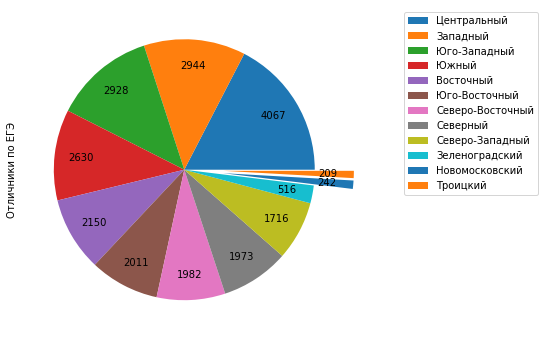

In [1]:
'''Соберите отчет по результатам ЕГЭ в 2018-2019 году, используя данные
https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv
и отправьте его в HTML формате по адресу support@ittensive.com, используя только Python.
В отчете должно быть:
общее число отличников (учеников, получивших более 220 баллов по ЕГЭ в Москве),
распределение отличников по округам Москвы,
название школы с лучшими результатами по ЕГЭ в Москве.
Диаграмма распределения должна быть вставлена в HTML через data:URI формат (в base64-кодировке).
Дополнительно: приложите к отчету PDF документ того же содержания (дублирующий письмо).
Сколько учеников набрало 220 и больше баллов по ЕГЭ в Москве в 2018-2019 году?'''

import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import binascii
import pdfkit
from jinja2 import Template
    
data = pd.read_csv("https://video.ittensive.com/python-advanced/data-9722-2019-10-14.utf.csv", delimiter=";")
data = data[data['YEAR'] == '2018-2019']
data = data.loc[:, ["EDU_NAME", "AdmArea", "PASSES_OVER_220"]].fillna(value=0)

data["AdmArea"] = data["AdmArea"].apply(lambda x:x.split(" ")[0]).astype("category")
data.columns = ['Название школы', "Округ", "Количество отличников"]
data = data.sort_values(['Количество отличников'], ascending=False)
pd.set_option('display.max_colwidth', 1000)

print('Общее число отличников по Москве в 2018-2019 году: ', data['Количество отличников'].sum(), 'человек.')

data_area = data.set_index("Округ")
data_area = data_area["Количество отличников"].groupby("Округ").sum().sort_values(ascending=False)


fig = plt.figure(figsize=(12,6))
area = fig.add_subplot(1, 1, 1)

explode = [0]*len(data_area)
explode[-1] = 0.3
explode[-2] = 0.3
total = sum(data_area)
data_area.plot.pie(ax=area, labels = ['']*len(data_area), label="Отличники по ЕГЭ", autopct=lambda x:int(round(total * x/100)),
                   pctdistance = 0.8, explode=explode)
plt.legend(data_area.index, bbox_to_anchor=(1.5,1,0.1,0))
img = BytesIO()
plt.savefig(img)

img = 'data:image/png;base64,' + binascii.b2a_base64(img.getvalue(), newline=False).decode("UTF-8")

html = Template(open('html_files/Distr_over_220_in_areas.html', encoding="utf-8").read()).render(data={
    'image': img,
    'table': data[:1].to_html()})

config = pdfkit.configuration(wkhtmltopdf='C:/Program Files/wkhtmltopdf/bin/wkhtmltopdf.exe')
options = {
    'page-size': 'A4',
    'header-right': '[page]'
}
    
pdfkit.from_string(html, 'Distr_over_220_in_areas.pdf',
                  configuration=config, options = options)

In [4]:
import smtplib
from email import encoders
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
# user_mail = 'почта отправителя'
# password = "пароль отправителя"
letter = MIMEMultipart()
letter["From"] = user_mail
letter["Subject"] = "Отчет по результатам ЕГЭ в 2018-2019 году"
letter["Content-Type"] = "text/html; charset=utf-8"
letter["To"] = "support@ittensive.com"
letter.attach(MIMEText(html, 'html'))
attachement = MIMEBase('application', 'pdf')
attachement.set_payload(open('Distr_over_220_in_areas.pdf', 'rb').read())            
attachement.add_header('Content-Disposition',
                      'attachement; filename="Distr_over_220_in_areas.pdf"')
encoders.encode_base64(attachement)
letter.attach(attachement)

server = smtplib.SMTP_SSL("smtp.mail.ru", 465)
server.login(user_mail, password)
server.sendmail(user_mail, "support@ittensive.com",
               letter.as_string())
server.quit()

(221, b'smtp57.i.mail.ru closing connection')